In [1]:
import h5py
import os
import sys
import tensorflow as tf
import numpy as np
from bm3d import bm3d_rgb, BM3DProfile
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import matplotlib.pyplot as plt


2025-08-05 14:49:12.109089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754430552.274512 1608558 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754430552.318309 1608558 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754430552.677211 1608558 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754430552.677232 1608558 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754430552.677234 1608558 computation_placer.cc:177] computation placer alr

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
print("here")

here


In [4]:
#image denoise methods to try
#arciteture only 2024 https://www.nature.com/articles/s41598-024-60139-x
# cascaded gaze 2019 https://github.com/Ascend-Research/CascadedGaze
# SwinIR 2021 https://github.com/JingyunLiang/SwinIR?tab=readme-ov-file
#scunet, ffdnet (compared in nature paper, very close to nat perf) or dnCNN  toolbox with many models https://github.com/cszn/KAIR
#scunet it python based 
# https://pypi.org/project/bm3d/ Bm3d also in nature paper

In [5]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [6]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [7]:
import numpy as np
import os

def encode_voxel_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                        y_train_3d, y_val_3d, y_test_3d,
                        ref_d=None, save_dir='scalers'):
    """
    Encode a batch of 3D volumes by normalizing each depth slice independently and replicating to RGB.
    Each input of shape (N, 64, 64, 64) is transformed into (N*64, 64, 64, 3).

    Args:
        *_3d: ndarray of shape (N, 64, 64, 64)
        ref_d: optional ndarray of shape (64, 64, 64)
        save_dir: directory to save the (min, max) scalers for each batch

    Returns:
        Tuple of:
            x_train_rgb, x_val_rgb, x_test_rgb,
            y_train_rgb, y_val_rgb, y_test_rgb,
            ref_d_rgb (or None if not provided)
    """
    os.makedirs(save_dir, exist_ok=True)

    def process_batch(batch, tag):
        N, D, H, W = batch.shape  # (N, 64, 64, 64)
        rgb_batch = np.zeros((N * D, H, W, 3), dtype=np.float32)
        all_mins = []
        all_maxs = []

        for i in range(N):
            mins = []
            maxs = []
            for d in range(D):
                slice_2d = batch[i, d, :, :]
                s_min = float(slice_2d.min())
                s_max = float(slice_2d.max())

                if s_max == s_min:
                    s_max = s_min + 1e-6  # prevent divide-by-zero

                normed = (slice_2d - s_min) / (s_max - s_min)
                rgb = np.stack([normed] * 3, axis=-1)  # shape: (64, 64, 3)

                rgb_batch[i * D + d] = rgb
                mins.append(s_min)
                maxs.append(s_max)

            all_mins.append(mins)
            all_maxs.append(maxs)

        np.savez(os.path.join(save_dir, f'{tag}_scalers.npz'),
                 mins=np.array(all_mins), maxs=np.array(all_maxs))

        return rgb_batch

    x_train_rgb = process_batch(x_train_3d, 'x_train')
    x_val_rgb   = process_batch(x_val_3d, 'x_val')
    x_test_rgb  = process_batch(x_test_3d, 'x_test')
    y_train_rgb = process_batch(y_train_3d, 'y_train')
    y_val_rgb   = process_batch(y_val_3d, 'y_val')
    y_test_rgb  = process_batch(y_test_3d, 'y_test')

    # Optional: single ref volume
    ref_d_rgb = None
    if ref_d is not None:
        ref_rgb = np.zeros((64, 64, 64, 3), dtype=np.float32)
        ref_mins = []
        ref_maxs = []
        for d in range(64):
            slice_2d = ref_d[d, :, :]
            s_min = float(slice_2d.min())
            s_max = float(slice_2d.max())

            if s_max == s_min:
                s_max = s_min + 1e-6

            normed = (slice_2d - s_min) / (s_max - s_min)
            ref_rgb[d] = np.stack([normed] * 3, axis=-1)
            ref_mins.append(s_min)
            ref_maxs.append(s_max)

        np.savez(os.path.join(save_dir, 'ref_d_scalers.npz'),
                 mins=np.array(ref_mins), maxs=np.array(ref_maxs))
        ref_d_rgb = ref_rgb

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb
    )


In [8]:
import numpy as np

def decode_rgb_to_voxel_batch(rgb_data, scaler_path):
    """
    Decode RGB-encoded batch (N*64, 64, 64, 3) back to original (N, 64, 64, 64) data
    using per-slice min/max scalers.

    Args:
        rgb_data: ndarray of shape (N*64, 64, 64, 3)
        scaler_path: path to `.npz` file containing 'mins' and 'maxs' arrays
                     of shape (N, 64)

    Returns:
        reconstructed: ndarray of shape (N, 64, 64, 64)
    """
    num_slices = 64
    assert rgb_data.ndim == 4 and rgb_data.shape[1:4] == (64, 64, 3), \
        f"Expected shape (N*64, 64, 64, 3), got {rgb_data.shape}"

    N = rgb_data.shape[0] // num_slices
    assert rgb_data.shape[0] == N * num_slices, "RGB data is not a multiple of 64 slices"

    scalers = np.load(scaler_path)
    mins = scalers['mins']  # shape (N, 64)
    maxs = scalers['maxs']  # shape (N, 64)

    reconstructed = np.zeros((N, 64, 64, 64), dtype=np.float32)

    for i in range(N):
        for d in range(num_slices):
            idx = i * num_slices + d
            normed = rgb_data[idx, :, :, 0]  # Use first channel (R), they are all the same
            s_min = mins[i, d]
            s_max = maxs[i, d]
            reconstructed[i, d, :, :] = normed * (s_max - s_min) + s_min

    return reconstructed


In [ ]:
x_train_rgb, x_val_rgb, x_test_rgb, \
y_train_rgb, y_val_rgb, y_test_rgb, \
ref_d_rgb = encode_voxel_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    ref_d=ref_d
)
print("done generating")

In [9]:
"""import os
save_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'
np.save(os.path.join(save_path, 'x_train_rgb_=3c.npy'), x_train_rgb)
np.save(os.path.join(save_path, 'x_val_rgb_=3c.npy'), x_val_rgb)
np.save(os.path.join(save_path, 'x_test_rgb_=3c.npy'), x_test_rgb)
np.save(os.path.join(save_path, 'y_train_rgb_=3c.npy'), y_train_rgb)
np.save(os.path.join(save_path, 'y_val_rgb_=3c.npy'), y_val_rgb)
np.save(os.path.join(save_path, 'y_test_rgb_=3c.npy'), y_test_rgb)
np.save(os.path.join(save_path, 'ref_d_rgb_=3c.npy'), ref_d_rgb)
import numpy as np"""

base_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'

x_train_rgb = np.load(f'{base_path}/x_train_rgb_=3c.npy')
x_val_rgb   = np.load(f'{base_path}/x_val_rgb_=3c.npy')
x_test_rgb  = np.load(f'{base_path}/x_test_rgb_=3c.npy')
y_train_rgb = np.load(f'{base_path}/y_train_rgb_=3c.npy')
y_val_rgb   = np.load(f'{base_path}/y_val_rgb_=3c.npy')
y_test_rgb  = np.load(f'{base_path}/y_test_rgb_=3c.npy')
ref_d_rgb   = np.load(f'{base_path}/ref_d_rgb_=3c.npy')
print("done")

done


In [10]:
print(x_train_rgb.shape)
print(x_test_rgb.shape)
print(x_val_rgb.shape)
print(y_val_rgb.shape)
print(y_train_rgb.shape)
print(y_test_rgb.shape)

(64000, 64, 64, 3)
(640, 64, 64, 3)
(6400, 64, 64, 3)
(6400, 64, 64, 3)
(64000, 64, 64, 3)
(640, 64, 64, 3)


In [11]:
x_train_rgb = x_train_rgb[63000:] 
x_val_rgb   = x_val_rgb[6300:]
x_test_rgb  = x_test_rgb[630:] 
y_train_rgb = y_train_rgb[63000:]
y_val_rgb   = y_val_rgb[6300:]
y_test_rgb = y_test_rgb[630:] 

In [12]:
print(x_train_rgb.shape)
print(x_test_rgb.shape)
print(x_val_rgb.shape)
print(y_val_rgb.shape)
print(y_train_rgb.shape)
print(y_test_rgb.shape)

(1000, 64, 64, 3)
(10, 64, 64, 3)
(100, 64, 64, 3)
(100, 64, 64, 3)
(1000, 64, 64, 3)
(10, 64, 64, 3)


In [13]:
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir)
from models.network_scunet import SCUNet as SCUNet
import numpy as np

from torch.utils.data import Dataset
import torch
import numpy as np

class RGBDenoiseDataset(Dataset):
    def __init__(self, x, y):
        # Normalize to [0, 1] and permute axes to (N, C, H, W)
        self.x = torch.tensor(np.transpose(x, (0, 3, 1, 2)), dtype=torch.float32) 
        self.y = torch.tensor(np.transpose(y, (0, 3, 1, 2)), dtype=torch.float32) 

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


from torch.utils.data import DataLoader

# Datasets
train_dataset = RGBDenoiseDataset(x_train_rgb, y_train_rgb)
val_dataset   = RGBDenoiseDataset(x_val_rgb, y_val_rgb)
test_dataset  = RGBDenoiseDataset(x_test_rgb, y_test_rgb)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
test_loader  = DataLoader(test_dataset, batch_size=1)


In [14]:


import torch
import sys
from models.network_scunet import SCUNet

# Add module path and import
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet"
sys.path.insert(0, module_dir)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCUNet(in_nc=3, config=[4, 4, 4, 4, 4, 4, 4], dim=64)

# Load pretrained weights
model_path = '/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet/model_zoo/scunet_color_25.pth'
model.load_state_dict(torch.load(model_path, map_location=device), strict=True)
model = model.to(device)


Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

In [15]:
for param in model.parameters():
    param.requires_grad = True
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 5  # adjust as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    
    # Optionally evaluate on val_loader each epoch
torch.save(model, 'scunet_finetuned')


Epoch [1/5], Loss: 0.005385
Epoch [2/5], Loss: 0.002765
Epoch [3/5], Loss: 0.002576
Epoch [4/5], Loss: 0.002378
Epoch [5/5], Loss: 0.002322


In [18]:
torch.save(model.state_dict(), 'scunet_finetuned_state.pth')


In [11]:
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir)
from models.network_scunet import SCUNet as SCUNet
import numpy as np

from torch.utils.data import Dataset
import torch
import numpy as np
test = torch.load('scunet_finetuned', map_location='cpu', weights_only=False)
test.eval()


SCUNet(
  (m_head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (m_down1): Sequential(
    (0): ConvTransBlock(
      (trans_block): Block(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (msa): WMSA(
          (embedding_layer): Linear(in_features=32, out_features=96, bias=True)
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (drop_path): Identity()
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (conv1_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv1_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pa

In [25]:
from utils import utils_image as util

def denoise_with_scunet(rgb_image_np, model, device='cuda'):
    """
    Args:
        rgb_image_np: (H, W, 3), float32 or float64, values in [0,1]
        model: SCUNet model
        device: 'cuda' or 'cpu'
    
    Returns:
        Denoised image (H, W, 3), uint8
    """
    # Make sure image is float32 in [0,1]
    img = rgb_image_np.astype(np.float32)
    img_tensor = util.single2tensor4(img).to(device)
    with torch.no_grad():
        output_tensor = model(img_tensor)
    output_np = util.tensor2single(output_tensor)
    return np.clip(output_np.transpose(1, 2, 0), 0, 1)


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scunet_denoised = denoise_with_scunet(x_train_rgb[0], model, device=device)


(64, 64, 3)


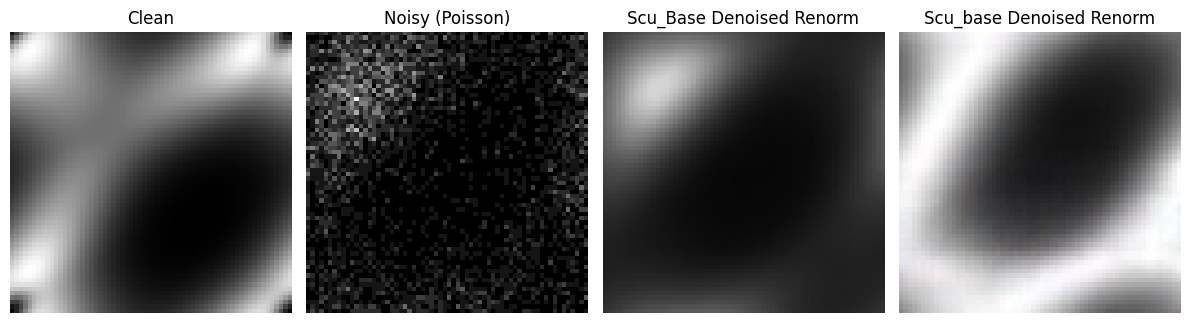

In [28]:
import matplotlib.pyplot as plt
x_clean = ref_d_rgb            # shape: (64, 64, 3), dtype: float32
                              # or whatever sampling parameter you want
x_noisy = x_train_rgb[0] 
x_denoised = np.transpose(scunet_denoised, (0,2,1))
print(x_denoised.shape)

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(ref_d_rgb[0])
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(x_noisy)
axs[1].set_title("Noisy (Poisson)")
axs[1].axis("off")


axs[2].imshow(x_denoised)
axs[2].set_title("Scu_Base Denoised Renorm")
axs[2].axis("off")

def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * 1), 0, 1)

#might need to be renormalized because max is no longer 1
renorm_den = normalize_per_sample(x_denoised)
axs[3].imshow(renorm_den)
axs[3].set_title("Scu_base Denoised Renorm")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [29]:
print(np.max(x_clean))
print(np.sum(x_clean,axis=(0,1,2)))
print()
print(np.max(x_noisy))
print(np.sum(x_noisy,axis=(0,1,2)))
print()
print(np.max(np.clip(x_denoised, 0, 1)))
print(np.sum(np.clip(x_denoised, 0, 1),axis=(0,1,2)))
print()
print(np.max(np.clip(renorm_den, 0, 1)))
print(np.sum(np.clip(renorm_den, 0, 1),axis=(0,1,2)))



1.0
[69873.36 69873.36 69873.36]

1.0
1049.5

0.841368
2415.362

1.0
6659.1963


In [41]:
def jensen_shannon_divergence_loss(y_true, y_pred, eps=1e-8):
    # Flatten to (batch_size, features)
    y_t = y_true.reshape(y_true.size(0), -1)
    y_p = y_pred.reshape(y_pred.size(0), -1)

    # Normalize to get probability distributions
    y_t = y_t / (y_t.sum(dim=1, keepdim=True) + eps)
    y_p = y_p / (y_p.sum(dim=1, keepdim=True) + eps)

    m = 0.5 * (y_t + y_p)

    kl_true = (y_t * torch.log((y_t + eps) / (m + eps))).sum(dim=1)
    kl_pred = (y_p * torch.log((y_p + eps) / (m + eps))).sum(dim=1)

    jsd = 0.5 * (kl_true + kl_pred)
    return jsd.mean()


In [42]:
print(x_noisy.shape)
print(x_denoised.shape)
print(x_clean.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 64, 3)


In [43]:
jsd_noisy = jensen_shannon_divergence_loss(
    torch.tensor(x_noisy, dtype=torch.float32).to(device),
    torch.tensor(x_clean[0], dtype=torch.float32).to(device)
)

jsd_original = jensen_shannon_divergence_loss(
    torch.tensor(x_denoised, dtype=torch.float32).to(device),
    torch.tensor(x_clean[0], dtype=torch.float32).to(device)
)

jsd_renormed = jensen_shannon_divergence_loss(
    torch.tensor(renorm_den, dtype=torch.float32).to(device),
    torch.tensor(x_clean[0], dtype=torch.float32).to(device)
)

print(f"JSD (x_noisy vs ref_d_rgb): {jsd_noisy.item():.6f}")
print(f"JSD (x_denoised vs ref_d_rgb): {jsd_original.item():.6f}")
print(f"JSD (renormalized vs ref_d_rgb): {jsd_renormed.item():.6f}")


JSD (x_noisy vs ref_d_rgb): 0.254033
JSD (x_denoised vs ref_d_rgb): 0.103529
JSD (renormalized vs ref_d_rgb): 0.103529
